In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !unzip -u "/content/drive/My Drive/ECG5000.zip" -d "/content/drive/My Drive/ECG5000"

In [5]:
!pip install arff2pandas

  Created wheel for arff2pandas: filename=arff2pandas-1.0.1-cp36-none-any.whl size=2199 sha256=e1872cdc43d97c581761450d320b5231370753daee689829615a72c26c650e48
  Stored in directory: /root/.cache/pip/wheels/b9/45/8c/f5549147a19665e4358e6b463bfdd0cb770f6ef38f3e137284
  Created wheel for liac-arff: filename=liac_arff-2.5.0-cp36-none-any.whl size=11734 sha256=3cb18895ddecaa8c49485de56c838d5e658d27256fbfb2c7f7a45c3fdcfbe433
  Stored in directory: /root/.cache/pip/wheels/77/8d/b4/8bfce5beea9a3496cc15b24961876adb7b6e2912ff09164179
Successfully built arff2pandas liac-arff


## Importing library 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import copy

from sklearn.model_selection import train_test_split

import torch 
from torch import nn, optim
import torch.nn.functional as F

from arff2pandas import a2p

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Loading train and test file 
with open ('drive/My Drive/ECG5000/ECG5000_TRAIN.arff') as f: 
  train = a2p.load(f)

with open ('drive/My Drive/ECG5000/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [10]:
# Create dataset by combine both train and test together
data = train.append(test)

# Shuffle the dataset
data = data.sample(frac=1.0)

data has shape of (5000, 141): 5000 datapoints in 141 dimensions.

Each datapoint represents a single heartbeat record.

In the dataset we have 5 types of heartbeats (classes):


*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-Ventricular Premature or Ectopic Beaet (SP or EB)
*   Unclassified Beat (UB)







In [11]:
# Name the possible classes
CLASS_NORMAL = 1

class_names = ['Normal','PVC','R on T', 'SP','UB']

In [12]:
# Rename columns
new_columns = list(data.columns)
new_columns[-1] = 'target'
data.columns = new_columns

## Data Exploration

In [13]:
# how many examples does each class have: 
data.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


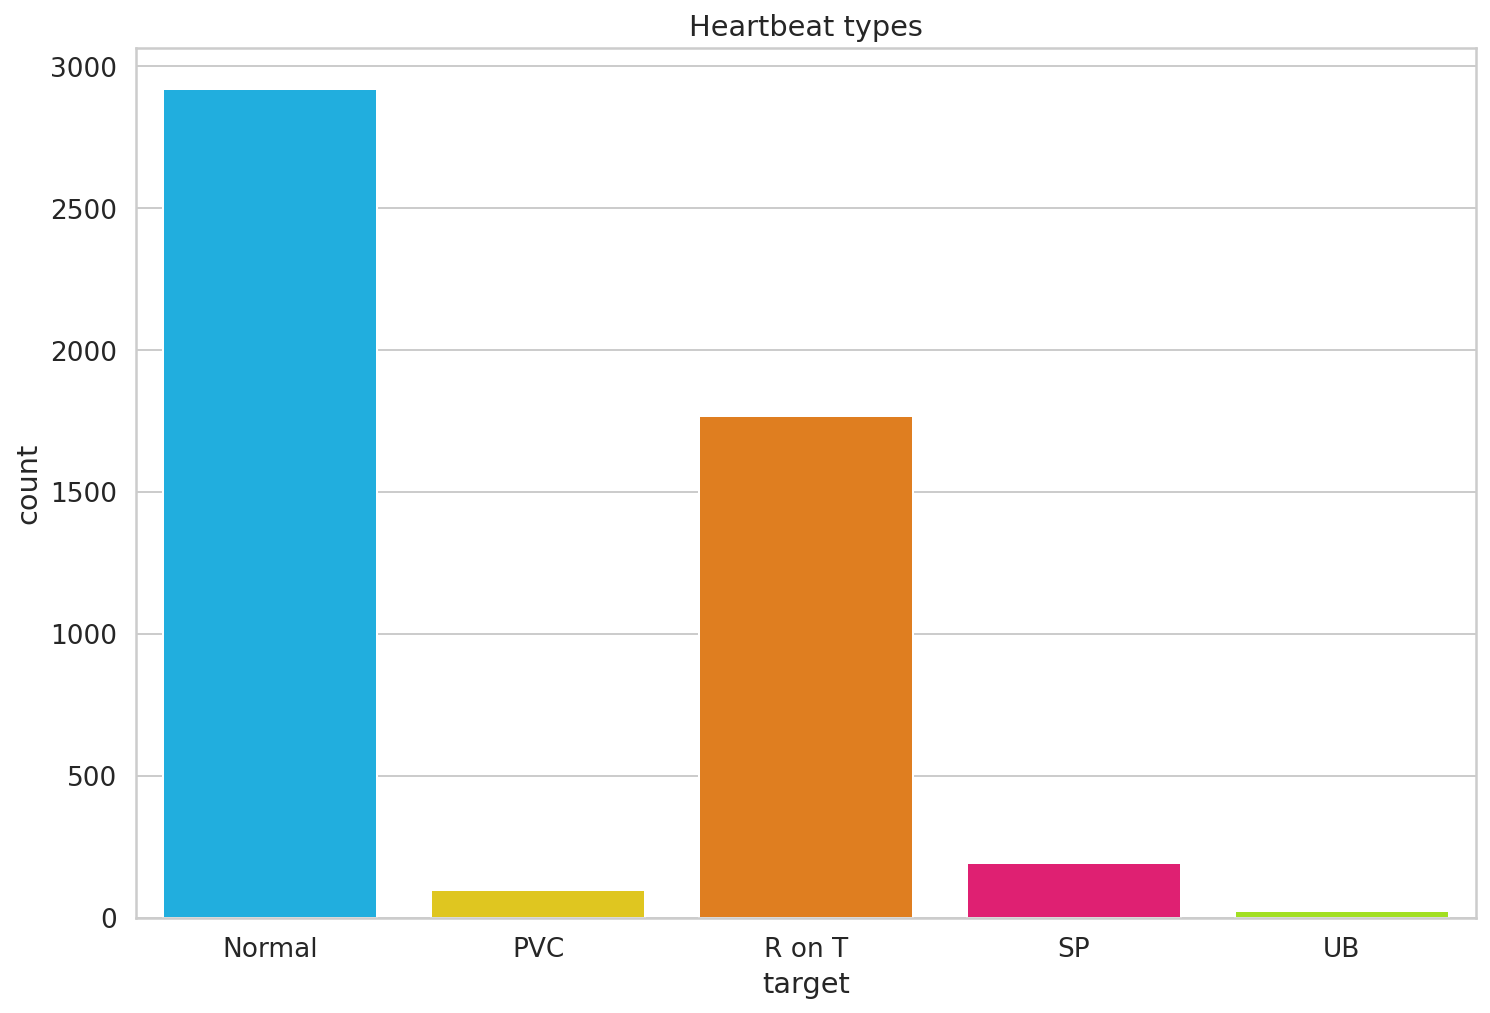

In [14]:
# Plot type of heartbeats:
ax = sns.countplot(data.target)
ax.set_xticklabels(class_names)
ax.set_title('Heartbeat types');

The normal class by far has the most examples. 

The aim of the model is to dectect normal heartbeats and distinguise with anomaly heartbeats.

Averaged Time Series for each class  (with smoothed out with 1 standard deviation on top and bottom)

In [15]:
def plot_time_series_class(data, class_name, ax, n_steps = 10):
  # Turn input data into dataframe
  time_series_df = pd.DataFrame(data)

  # Taking the mean of n_steps rolling 
  smooth_path = time_series_df.rolling(n_steps).mean()
  # Taking standard deviaion for the new smoothed curve
  path_deviation = 2 * time_series_df.rolling(n_steps).std()
  
  # Computing under_line and over_line for the average time series (smoothed curve)
  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  # Plot the new smoothed curves of each class.
  ax.plot(smooth_path, linewidth = 2)
  ax.fill_between(path_deviation.index, 
                  under_line, 
                  over_line, 
                  alpha = 0.125)
  ax.set_title(class_name)


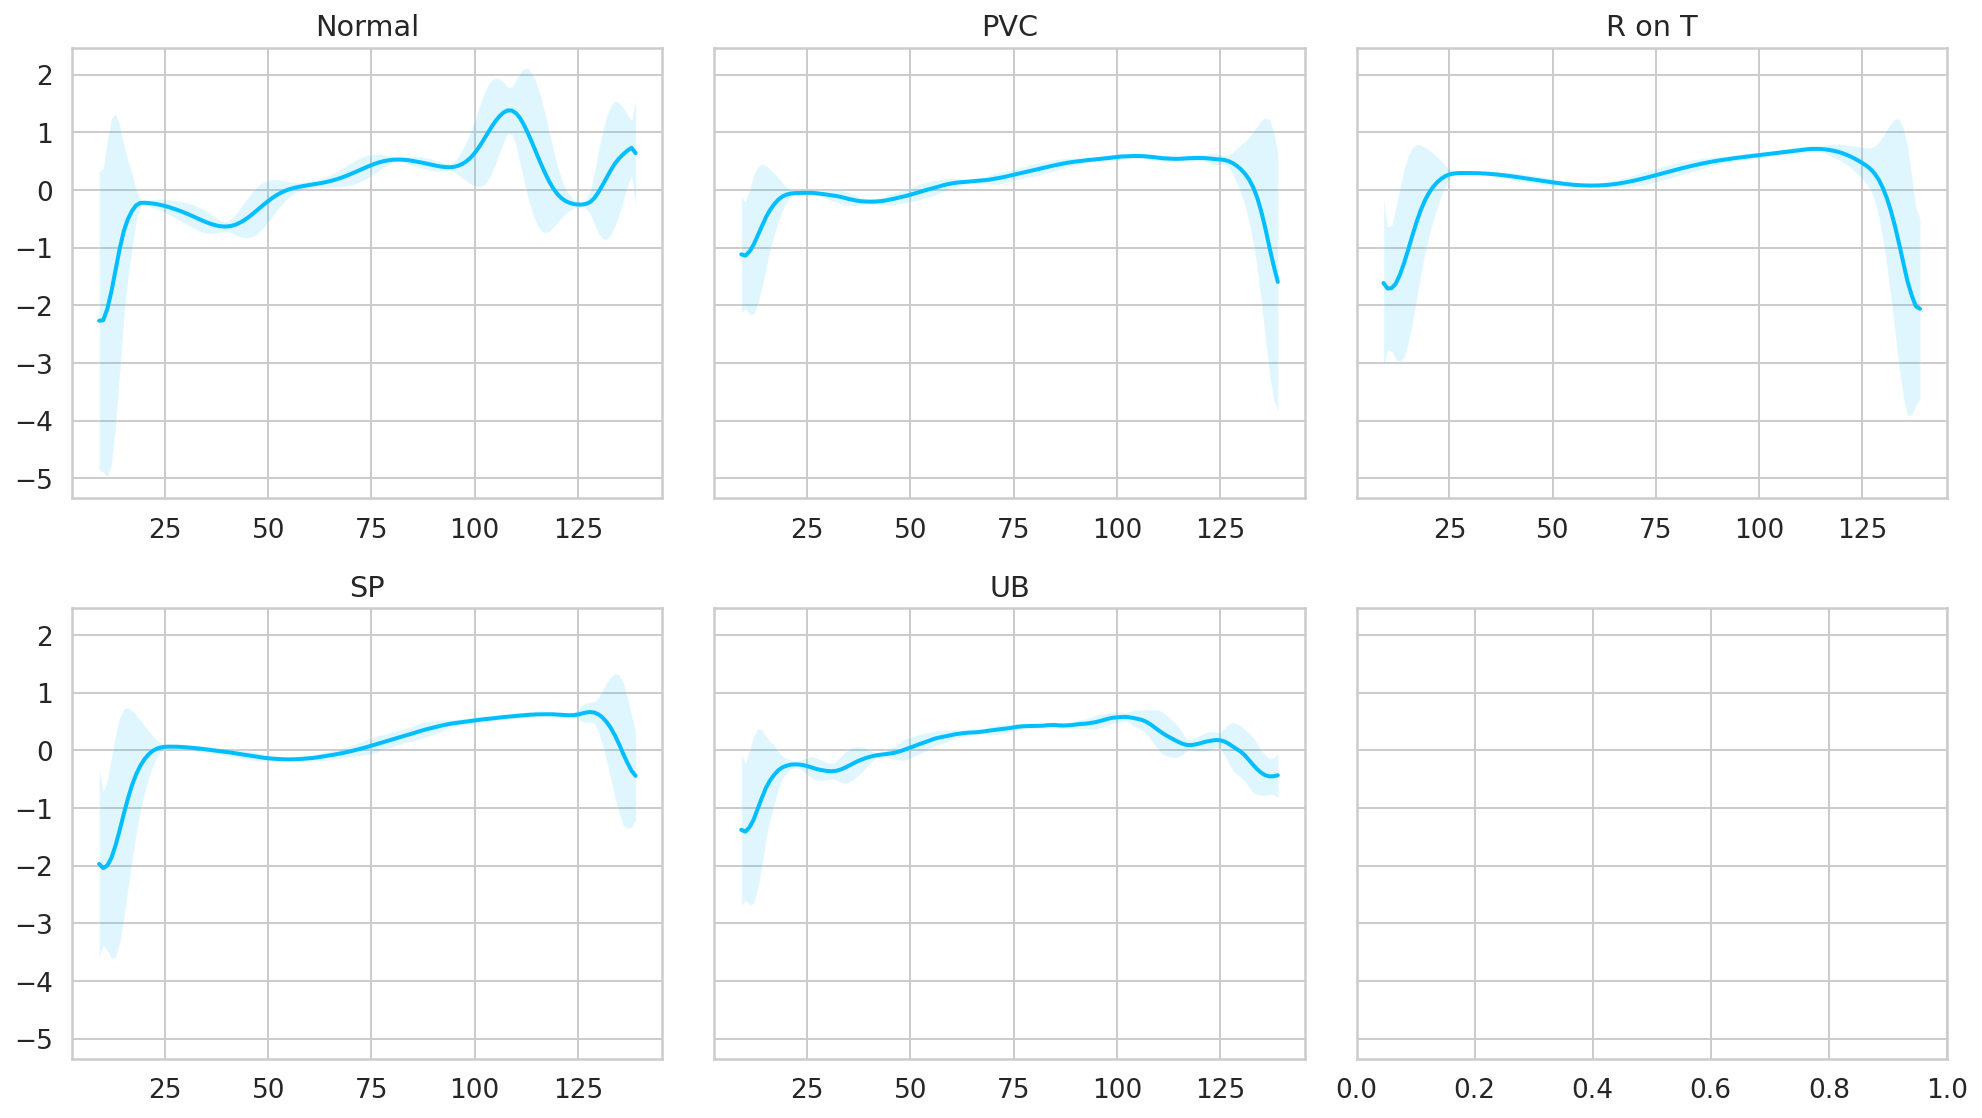

In [16]:
# Getting all the classes [0,1,2,3,4]
classes = data.target.unique()

fig, axs = plt.subplots(nrows = len(classes)//3+1,
                        ncols = 3,
                        sharey = True, 
                        figsize = (14,8))

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  df = data[data.target == cls]\
        .drop(labels = 'target', axis = 1)\
        .mean(axis=0)\
        .to_numpy()
  plot_time_series_class(df, class_names[i], ax)

  # fig.delaxes(axs.flat[-1])
  fig.tight_layout();

We clearly can see that the graph have indicated that the normal heartbeat class has a distinctly different pattern compares to all other classes. 

### LSTM Autoencoder for Anomaly Detection.


Data Preprocessing

In [17]:
# Get all normal heartbeats and drop target column:
normal_data = data[data.target == str(CLASS_NORMAL)]\
                  .drop(labels='target', axis=1)

In [18]:
# Merge all the other classes and mark them as anomalies:
anomaly_data = data[data.target != str(CLASS_NORMAL)]\
                    .drop(labels = 'target', axis = 1)

In [19]:
# split the normal examples into train, validation and test sets (80,10,10):
train_df, val_df = train_test_split(normal_data, 
                                    test_size = 0.2,
                                    random_state = RANDOM_SEED)

val_df, test_df = train_test_split(val_df, 
                                   test_size = .5,
                                   random_state = RANDOM_SEED)

In [20]:
# Convert data into 2D Tensors in shape sequence length x number of features (1,140,1)

def create_dataset(df):
  # Turn dataframe to list of list
  sequences = df.astype(np.float32).to_numpy().tolist()
  # Convert every elements of the list into tensor
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  # Number of sequences, sequence length, number of features of each sequence
  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features



In [21]:
# Create dataset
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _ , _ = create_dataset(val_df)
test_normal_dataset, _ , _ = create_dataset(test_df)
val_anomaly_dataset, _ , _ = create_dataset(anomaly_data)


LSTM autoencoder model creation

In [22]:
# Encoder with 2 LSTM layers to compress the input data.
class Encoder(nn.Module):

  def __init__(self, batch_size, seq_len, n_features, embedding_dim = 64):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.n_features = n_features
    self.embedding_dim = embedding_dim
    self.hidden_dim = 2 * embedding_dim

    self.rnn1 = nn.LSTM(input_size = self.n_features,
                        hidden_size = self.hidden_dim,
                        num_layers = 1, 
                        batch_first = True)
    
    self.rnn2 = nn.LSTM(input_size = self.hidden_dim, 
                        hidden_size = self.embedding_dim,
                        num_layers = 1,
                        batch_first = True)
    
  def forward(self, x):
    x = x.reshape((self.batch_size, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n,_) = self.rnn2(x)

    return hidden_n.reshape((self.batch_size, self.embedding_dim))

In [23]:
# Decoder with 2 LSTM layers and 1 output layers that gives the final reconstruction.
class Decoder(nn.Module):

  def __init__(self, batch_size, seq_len, input_dim = 64, n_features = 1):
    super(Decoder, self).__init__()

    self.batch_size = batch_size
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = 2 * input_dim
    self.n_features  = n_features

    self.rnn1 = nn.LSTM(input_size = input_dim,
                        hidden_size = input_dim,
                        num_layers = 1, 
                        batch_first = True)
    
    self.rnn2 = nn.LSTM(input_size = input_dim,
                        hidden_size = self.hidden_dim,
                        num_layers = 1, 
                        batch_first = True)
    
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, 1)
    x = x.reshape((self.batch_size, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [24]:
# Construct the complete LSTM autoencoder.
class RecurrentAutoencoder(nn.Module):
  def __init__(self, batch_size, seq_len, n_features, embedding_dim = 64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(batch_size, seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(batch_size, seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [25]:
batch_size = 1
model = RecurrentAutoencoder(batch_size, seq_len, n_features,128)
model = model.to(device)

### Training loop

In [26]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  # Using Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
  # Using MAE
  criterion = nn.L1Loss(reduction = 'sum').to(device)
  history = dict(train=[], val=[])

  # Saving best model
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  # Training loop
  for epoch in range(1,n_epochs+1):
    # Training data
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      # Load input data
      seq_true = seq_true.to(device)

      # Forwards
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)

      # Backwards
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
  
    # Validation
    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        # Load input data
        seq_true = seq_true.to(device)

        # Forwards
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)

        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_losses)
    history['val'].append(train_losses)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f'Epoch {epoch}: train loss {train_loss}, val loss {val_loss}')

    model.load_state_dict(best_model_wts)
  return model.eval(), history

In [27]:
n_epochs = 50
model, history = train_model(model, train_dataset, val_dataset, n_epochs)

Epoch 1: train loss 65.17977113417436, val loss 55.15537109113719
Epoch 2: train loss 54.63946599204739, val loss 52.026390585180835
Epoch 3: train loss 53.96763190651348, val loss 54.91837641311018
Epoch 4: train loss 54.88047984284558, val loss 52.94164119354666
Epoch 5: train loss 55.365181433210026, val loss 52.43198969592787
Epoch 6: train loss 54.3805064044111, val loss 52.79325924180959
Epoch 7: train loss 51.64348856499159, val loss 40.31346238149356
Epoch 8: train loss 42.782921509262835, val loss 38.22190906576915
Epoch 9: train loss 42.22030780677877, val loss 38.04905758491934
Epoch 10: train loss 41.99684157075412, val loss 37.93955030833205
Epoch 11: train loss 41.77679943272593, val loss 37.829612163648214
Epoch 12: train loss 38.64768721439599, val loss 34.956470424181795
Epoch 13: train loss 33.95960466111242, val loss 29.638932714723563
Epoch 14: train loss 30.268061325432658, val loss 27.834827103026925
Epoch 15: train loss 28.021201812123333, val loss 24.96340321841

In [28]:
# Saving model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

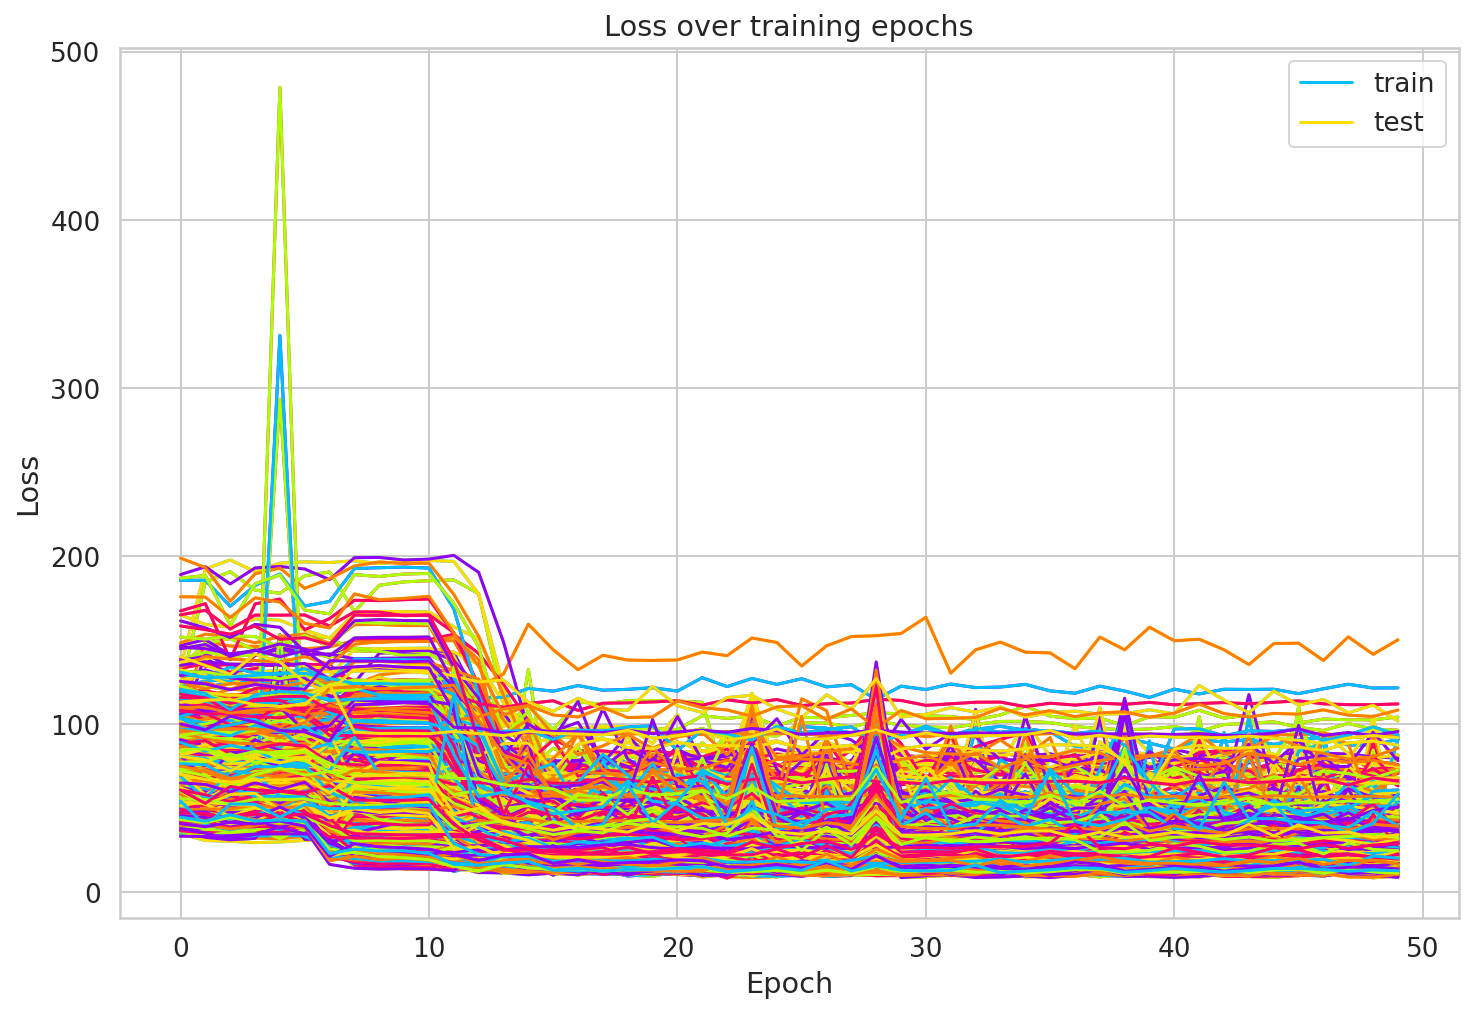

In [29]:
# Plot training and validation errors. 
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'])
plt.title('Loss over training epochs')
plt.show()

### Choosing Threshold.

we now turn our problem into Binary classification problem with the normal heartbeats will have loss < Threshold we chose. Meanwhile, anomaly heartbeats will have error > than a Threshold. 

In [32]:
def predict(model, dataset):
  predictions = []
  losses = []
  criterion = nn.L1Loss(reduction = 'sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      # Loading data to device
      seq_true = seq_true.to(device)

      # Forward 
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


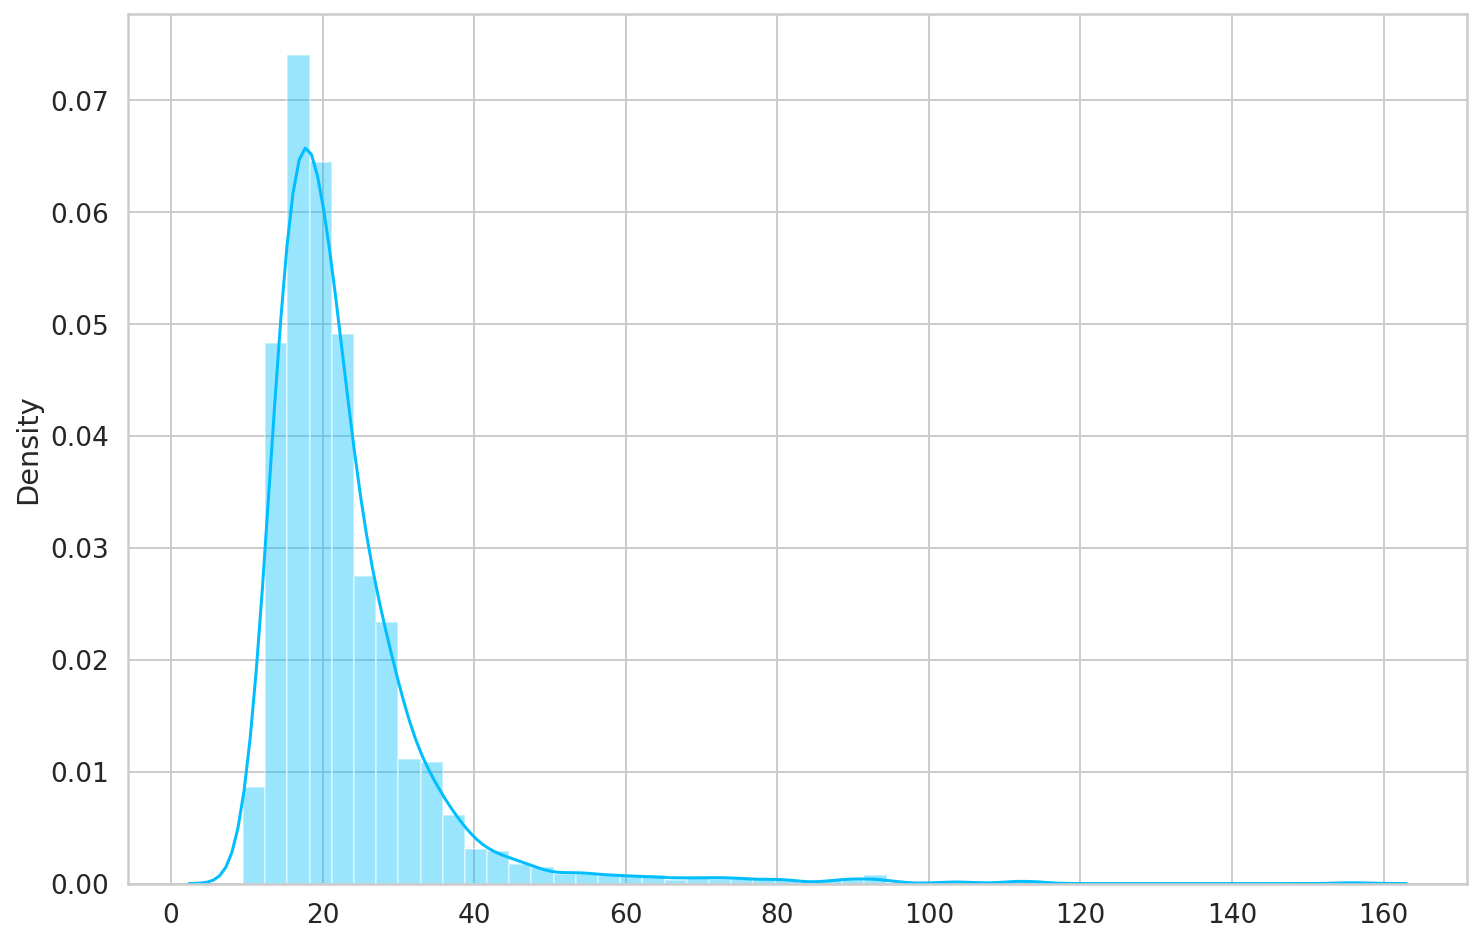

In [33]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde = True)

### Evaluation using choosen threshold. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


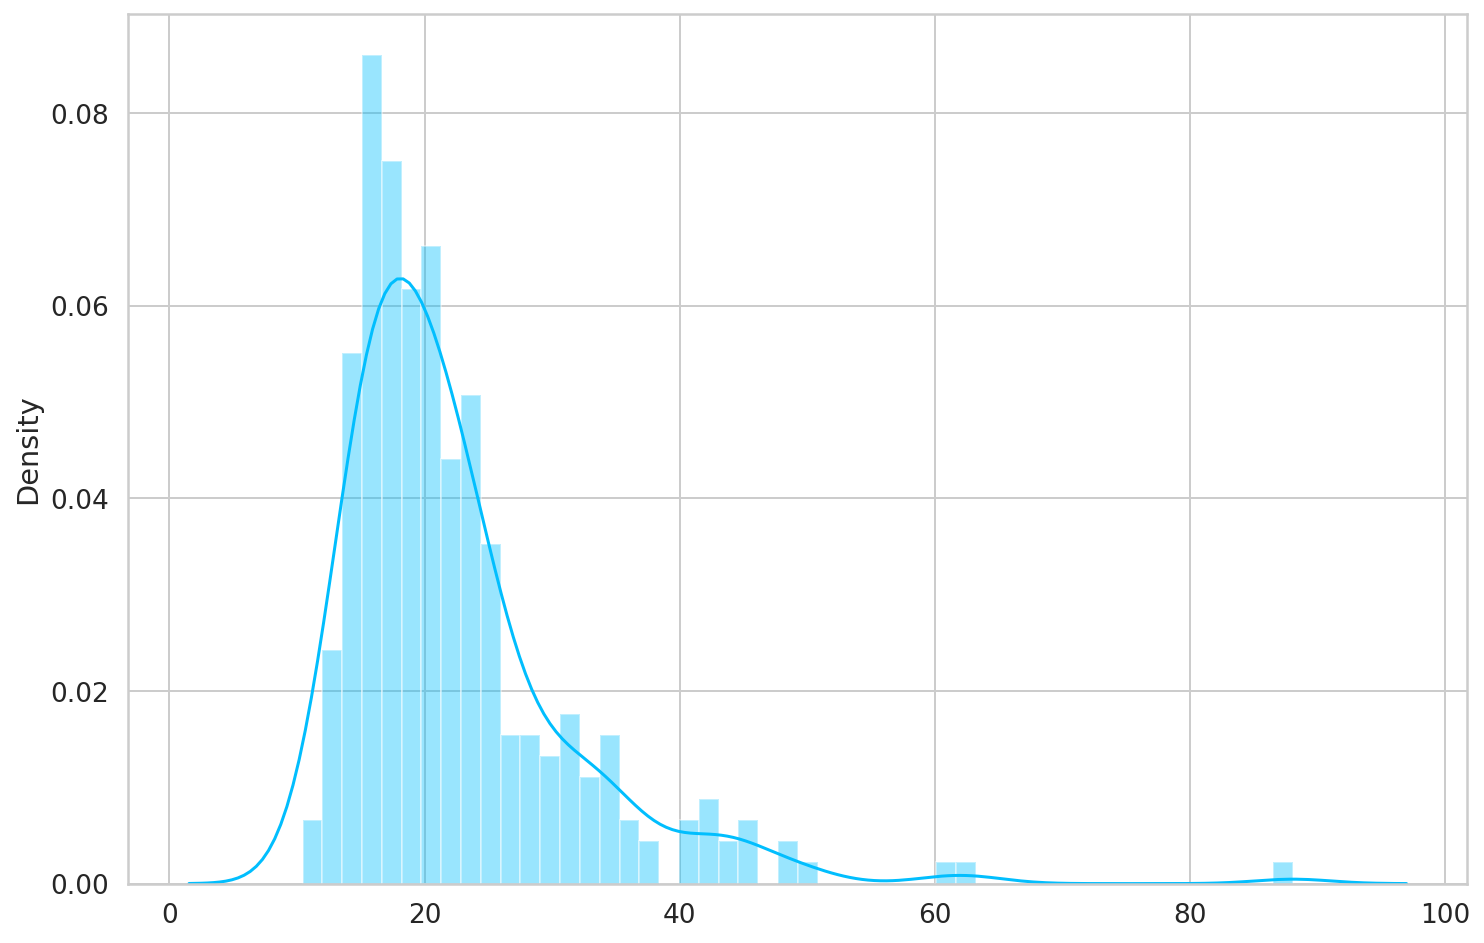

In [34]:
# Normal heartbeats.
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins = 50, kde = True)

In [38]:
# Counting the correct prediction with threshold 

THRESHOLD = 26
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal prediction: {correct} / {len(test_normal_dataset)}')

Correct normal prediction: 231 / 292


## Anomalies checking

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


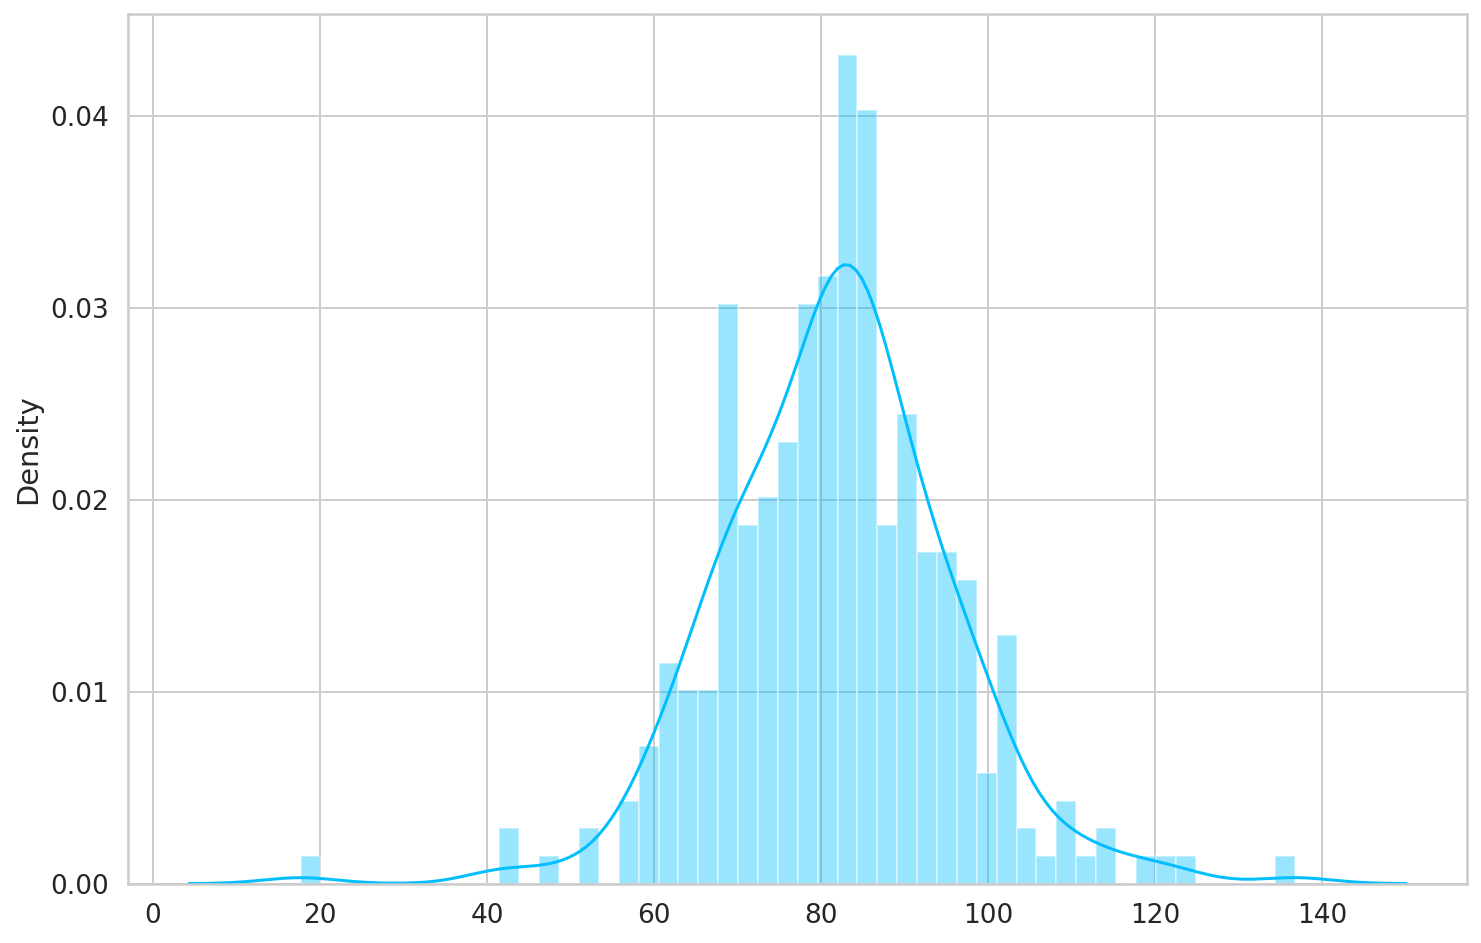

In [39]:
# Choosing a subset from anomaly dataset, which has the same length as normal dataset.
anomaly_dataset = val_anomaly_dataset[:len(test_normal_dataset)]

# Making prediction on anomaly dataset. 
prediction, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde = True)

In [44]:
# Counting the correct prediction with threshold 

correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly prediction: {correct}/{len(anomaly_dataset)}')

Correct anomaly prediction: 291/292
